In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [4]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [5]:
X.shape

(16396, 224, 224, 3)

In [6]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [7]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False)

In [8]:
filename = 'cg-inceptionv3features.npy'
if os.path.exists(filename):
    print("Loading Inceptionv3 extracted features from %s ..." %(filename))
    inceptionv3features = np.load(filename)
else:
    print("Extracting features from Inceptionv3 layers ...")
    inceptionv3features = base_model.predict(X)
    print("Saving Inceptionv3 extracted features into %s ..." %(filename))
    np.save(filename, inceptionv3features)

Loading Inceptionv3 extracted features from cg-inceptionv3features.npy ...


In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=400
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-inceptionv3-1layer-160neurons-relu-Adam-400epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = inceptionv3features[train_indices]
    Y_train = Y[train_indices]
    X_test = inceptionv3features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=inceptionv3features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    x = Dense(160, activation='relu', name='fc1')(x)
    x = Dropout(0.4)(x)
    x = Dense(160, activation='relu', name='fc2')(x)
    x = Dropout(0.4)(x)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 14755 samples, validate on 1641 samples
Epoch 1/400
14755/14755 [==============================] - 3s - loss: 0.9051 - acc: 0.5172 - val_loss: 1.7154 - val_acc: 0.4881
Epoch 2/400
14755/14755 [==============================] - 2s - loss: 1.6891 - acc: 0.4885 - val_loss: 0.6356 - val_acc: 0.6228
Epoch 3/400
14755/14755 [==============================] - 2s - loss: 0.7268 - acc: 0.5897 - val_loss: 0.7504 - val_acc: 0.5125
Epoch 4/400
14755/14755 [==============================] - 2s - loss: 0.8160 - acc: 0.5545 - val_loss: 0.7948 - val_acc: 0.5119
Epoch 5/400
14755/14755 [==============================] - 2s - loss: 0.8509 - acc: 0.5385 - val_loss: 0.6906 - val_acc: 0.5131
Epoch 6/400
14755/14755 [==============================] - 2s - loss: 0.7487 - acc: 0.5513 - val_loss: 0.6199 - val_acc: 0.5497
Epoch 7/400
14755/14755 [==============================] - 2s - loss: 0.6690 - acc: 0.5803 - val_loss: 0.6060 - val_acc: 0.7044
Epoch 8/400
14755/14755 [==============================

14755/14755 [==============================] - 2s - loss: 0.2198 - acc: 0.9136 - val_loss: 0.2350 - val_acc: 0.9007
Epoch 65/400
14755/14755 [==============================] - 2s - loss: 0.2208 - acc: 0.9126 - val_loss: 0.2342 - val_acc: 0.8988
Epoch 66/400
14755/14755 [==============================] - 2s - loss: 0.2174 - acc: 0.9141 - val_loss: 0.2334 - val_acc: 0.9001
Epoch 67/400
14755/14755 [==============================] - 2s - loss: 0.2182 - acc: 0.9151 - val_loss: 0.2328 - val_acc: 0.9007
Epoch 68/400
14755/14755 [==============================] - 2s - loss: 0.2151 - acc: 0.9171 - val_loss: 0.2324 - val_acc: 0.8995
Epoch 69/400
14755/14755 [==============================] - 2s - loss: 0.2131 - acc: 0.9175 - val_loss: 0.2310 - val_acc: 0.9037
Epoch 70/400
14755/14755 [==============================] - 2s - loss: 0.2117 - acc: 0.9187 - val_loss: 0.2300 - val_acc: 0.9043
Epoch 71/400
14755/14755 [==============================] - 2s - loss: 0.2072 - acc: 0.9198 - val_loss: 0.2297

14755/14755 [==============================] - 2s - loss: 0.1360 - acc: 0.9513 - val_loss: 0.2289 - val_acc: 0.9086
Epoch 128/400
14755/14755 [==============================] - 2s - loss: 0.1354 - acc: 0.9484 - val_loss: 0.2283 - val_acc: 0.9080
Epoch 129/400
14755/14755 [==============================] - 2s - loss: 0.1342 - acc: 0.9520 - val_loss: 0.2280 - val_acc: 0.9068
Epoch 130/400
14755/14755 [==============================] - 2s - loss: 0.1328 - acc: 0.9511 - val_loss: 0.2287 - val_acc: 0.9080
Epoch 131/400
14755/14755 [==============================] - 2s - loss: 0.1311 - acc: 0.9516 - val_loss: 0.2296 - val_acc: 0.9086
Epoch 132/400
14755/14755 [==============================] - 2s - loss: 0.1358 - acc: 0.9488 - val_loss: 0.2280 - val_acc: 0.9074
Epoch 133/400
14755/14755 [==============================] - 2s - loss: 0.1303 - acc: 0.9519 - val_loss: 0.2277 - val_acc: 0.9068
Epoch 134/400
14755/14755 [==============================] - 2s - loss: 0.1299 - acc: 0.9513 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0770 - acc: 0.9731 - val_loss: 0.2623 - val_acc: 0.9104
Epoch 191/400
14755/14755 [==============================] - 2s - loss: 0.0775 - acc: 0.9734 - val_loss: 0.2701 - val_acc: 0.9129
Epoch 192/400
14755/14755 [==============================] - 2s - loss: 0.0760 - acc: 0.9721 - val_loss: 0.2693 - val_acc: 0.9129
Epoch 193/400
14755/14755 [==============================] - 2s - loss: 0.0792 - acc: 0.9715 - val_loss: 0.2610 - val_acc: 0.9129
Epoch 194/400
14755/14755 [==============================] - 2s - loss: 0.0761 - acc: 0.9734 - val_loss: 0.2605 - val_acc: 0.9110
Epoch 195/400
14755/14755 [==============================] - 2s - loss: 0.0773 - acc: 0.9724 - val_loss: 0.2627 - val_acc: 0.9104
Epoch 196/400
14755/14755 [==============================] - 2s - loss: 0.0748 - acc: 0.9738 - val_loss: 0.2715 - val_acc: 0.9116
Epoch 197/400
14755/14755 [==============================] - 2s - loss: 0.0744 - acc: 0.9740 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0443 - acc: 0.9833 - val_loss: 0.3222 - val_acc: 0.9104
Epoch 254/400
14755/14755 [==============================] - 2s - loss: 0.0441 - acc: 0.9833 - val_loss: 0.3189 - val_acc: 0.9104
Epoch 255/400
14755/14755 [==============================] - 2s - loss: 0.0428 - acc: 0.9841 - val_loss: 0.3191 - val_acc: 0.9122
Epoch 256/400
14755/14755 [==============================] - 2s - loss: 0.0415 - acc: 0.9870 - val_loss: 0.3267 - val_acc: 0.9129
Epoch 257/400
14755/14755 [==============================] - 2s - loss: 0.0460 - acc: 0.9842 - val_loss: 0.3268 - val_acc: 0.9129
Epoch 258/400
14755/14755 [==============================] - 2s - loss: 0.0406 - acc: 0.9856 - val_loss: 0.3281 - val_acc: 0.9141
Epoch 259/400
14755/14755 [==============================] - 2s - loss: 0.0434 - acc: 0.9844 - val_loss: 0.3276 - val_acc: 0.9110
Epoch 260/400
14755/14755 [==============================] - 2s - loss: 0.0411 - acc: 0.9864 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0266 - acc: 0.9910 - val_loss: 0.3984 - val_acc: 0.9104
Epoch 317/400
14755/14755 [==============================] - 2s - loss: 0.0265 - acc: 0.9909 - val_loss: 0.3930 - val_acc: 0.9086
Epoch 318/400
14755/14755 [==============================] - 2s - loss: 0.0267 - acc: 0.9906 - val_loss: 0.3838 - val_acc: 0.9104
Epoch 319/400
14755/14755 [==============================] - 2s - loss: 0.0268 - acc: 0.9909 - val_loss: 0.3771 - val_acc: 0.9110
Epoch 320/400
14755/14755 [==============================] - 2s - loss: 0.0273 - acc: 0.9906 - val_loss: 0.3851 - val_acc: 0.9141
Epoch 321/400
14755/14755 [==============================] - 2s - loss: 0.0274 - acc: 0.9899 - val_loss: 0.3924 - val_acc: 0.9104
Epoch 322/400
14755/14755 [==============================] - 2s - loss: 0.0266 - acc: 0.9904 - val_loss: 0.3956 - val_acc: 0.9135
Epoch 323/400
14755/14755 [==============================] - 2s - loss: 0.0262 - acc: 0.9911 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0197 - acc: 0.9930 - val_loss: 0.4445 - val_acc: 0.9141
Epoch 380/400
14755/14755 [==============================] - 2s - loss: 0.0165 - acc: 0.9949 - val_loss: 0.4631 - val_acc: 0.9135
Epoch 381/400
14755/14755 [==============================] - 2s - loss: 0.0193 - acc: 0.9932 - val_loss: 0.4591 - val_acc: 0.9122
Epoch 382/400
14755/14755 [==============================] - 2s - loss: 0.0191 - acc: 0.9933 - val_loss: 0.4430 - val_acc: 0.9129
Epoch 383/400
14755/14755 [==============================] - 2s - loss: 0.0195 - acc: 0.9926 - val_loss: 0.4304 - val_acc: 0.9135
Epoch 384/400
14755/14755 [==============================] - 2s - loss: 0.0189 - acc: 0.9934 - val_loss: 0.4314 - val_acc: 0.9153
Epoch 385/400
14755/14755 [==============================] - 2s - loss: 0.0179 - acc: 0.9944 - val_loss: 0.4485 - val_acc: 0.9141
Epoch 386/400
14755/14755 [==============================] - 2s - loss: 0.0199 - acc: 0.9930 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.2333 - acc: 0.9046 - val_loss: 0.2372 - val_acc: 0.9031
Epoch 42/400
14755/14755 [==============================] - 2s - loss: 0.2323 - acc: 0.9037 - val_loss: 0.2348 - val_acc: 0.9055
Epoch 43/400
14755/14755 [==============================] - 2s - loss: 0.2318 - acc: 0.9057 - val_loss: 0.2333 - val_acc: 0.9055
Epoch 44/400
14755/14755 [==============================] - 2s - loss: 0.2296 - acc: 0.9065 - val_loss: 0.2324 - val_acc: 0.9080
Epoch 45/400
14755/14755 [==============================] - 2s - loss: 0.2256 - acc: 0.9059 - val_loss: 0.2302 - val_acc: 0.9086
Epoch 46/400
14755/14755 [==============================] - 2s - loss: 0.2216 - acc: 0.9099 - val_loss: 0.2278 - val_acc: 0.9098
Epoch 47/400
14755/14755 [==============================] - 2s - loss: 0.2183 - acc: 0.9120 - val_loss: 0.2263 - val_acc: 0.9104
Epoch 48/400
14755/14755 [==============================] - 2s - loss: 0.2162 - acc: 0.9135 - val_loss: 0.2252

14755/14755 [==============================] - 2s - loss: 0.1082 - acc: 0.9605 - val_loss: 0.1993 - val_acc: 0.9257
Epoch 105/400
14755/14755 [==============================] - 2s - loss: 0.1053 - acc: 0.9611 - val_loss: 0.2036 - val_acc: 0.9226
Epoch 106/400
14755/14755 [==============================] - 2s - loss: 0.1033 - acc: 0.9614 - val_loss: 0.2024 - val_acc: 0.9226
Epoch 107/400
14755/14755 [==============================] - 2s - loss: 0.1013 - acc: 0.9631 - val_loss: 0.2053 - val_acc: 0.9250
Epoch 108/400
14755/14755 [==============================] - 2s - loss: 0.1023 - acc: 0.9603 - val_loss: 0.2031 - val_acc: 0.9232
Epoch 109/400
14755/14755 [==============================] - 2s - loss: 0.0980 - acc: 0.9638 - val_loss: 0.2007 - val_acc: 0.9250
Epoch 110/400
14755/14755 [==============================] - 2s - loss: 0.0966 - acc: 0.9631 - val_loss: 0.2051 - val_acc: 0.9263
Epoch 111/400
14755/14755 [==============================] - 2s - loss: 0.0954 - acc: 0.9648 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0407 - acc: 0.9864 - val_loss: 0.2575 - val_acc: 0.9281
Epoch 168/400
14755/14755 [==============================] - 2s - loss: 0.0401 - acc: 0.9869 - val_loss: 0.2675 - val_acc: 0.9238
Epoch 169/400
14755/14755 [==============================] - 2s - loss: 0.0433 - acc: 0.9850 - val_loss: 0.2663 - val_acc: 0.9214
Epoch 170/400
14755/14755 [==============================] - 2s - loss: 0.0402 - acc: 0.9864 - val_loss: 0.2617 - val_acc: 0.9263
Epoch 171/400
14755/14755 [==============================] - 2s - loss: 0.0381 - acc: 0.9888 - val_loss: 0.2669 - val_acc: 0.9196
Epoch 172/400
14755/14755 [==============================] - 2s - loss: 0.0378 - acc: 0.9878 - val_loss: 0.2664 - val_acc: 0.9238
Epoch 173/400
14755/14755 [==============================] - 2s - loss: 0.0373 - acc: 0.9877 - val_loss: 0.2637 - val_acc: 0.9238
Epoch 174/400
14755/14755 [==============================] - 2s - loss: 0.0360 - acc: 0.9891 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0176 - acc: 0.9948 - val_loss: 0.3322 - val_acc: 0.9250
Epoch 231/400
14755/14755 [==============================] - 2s - loss: 0.0180 - acc: 0.9945 - val_loss: 0.3423 - val_acc: 0.9220
Epoch 232/400
14755/14755 [==============================] - 2s - loss: 0.0187 - acc: 0.9947 - val_loss: 0.3254 - val_acc: 0.9220
Epoch 233/400
14755/14755 [==============================] - 2s - loss: 0.0185 - acc: 0.9946 - val_loss: 0.3256 - val_acc: 0.9238
Epoch 234/400
14755/14755 [==============================] - 2s - loss: 0.0169 - acc: 0.9955 - val_loss: 0.3292 - val_acc: 0.9232
Epoch 235/400
14755/14755 [==============================] - 2s - loss: 0.0186 - acc: 0.9938 - val_loss: 0.3342 - val_acc: 0.9257
Epoch 236/400
14755/14755 [==============================] - 2s - loss: 0.0168 - acc: 0.9951 - val_loss: 0.3358 - val_acc: 0.9244
Epoch 237/400
14755/14755 [==============================] - 2s - loss: 0.0161 - acc: 0.9953 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0097 - acc: 0.9974 - val_loss: 0.3965 - val_acc: 0.9226
Epoch 294/400
14755/14755 [==============================] - 2s - loss: 0.0114 - acc: 0.9971 - val_loss: 0.3898 - val_acc: 0.9232
Epoch 295/400
14755/14755 [==============================] - 2s - loss: 0.0102 - acc: 0.9978 - val_loss: 0.3831 - val_acc: 0.9244
Epoch 296/400
14755/14755 [==============================] - 2s - loss: 0.0093 - acc: 0.9978 - val_loss: 0.3871 - val_acc: 0.9232
Epoch 297/400
14755/14755 [==============================] - 2s - loss: 0.0120 - acc: 0.9964 - val_loss: 0.4036 - val_acc: 0.9208
Epoch 298/400
14755/14755 [==============================] - 2s - loss: 0.0115 - acc: 0.9965 - val_loss: 0.3965 - val_acc: 0.9208
Epoch 299/400
14755/14755 [==============================] - 2s - loss: 0.0098 - acc: 0.9974 - val_loss: 0.3759 - val_acc: 0.9257
Epoch 300/400
14755/14755 [==============================] - 2s - loss: 0.0102 - acc: 0.9968 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0083 - acc: 0.9974 - val_loss: 0.4126 - val_acc: 0.9244
Epoch 357/400
14755/14755 [==============================] - 2s - loss: 0.0071 - acc: 0.9980 - val_loss: 0.4104 - val_acc: 0.9238
Epoch 358/400
14755/14755 [==============================] - 2s - loss: 0.0068 - acc: 0.9984 - val_loss: 0.4172 - val_acc: 0.9244
Epoch 359/400
14755/14755 [==============================] - 2s - loss: 0.0068 - acc: 0.9984 - val_loss: 0.4215 - val_acc: 0.9226
Epoch 360/400
14755/14755 [==============================] - 2s - loss: 0.0063 - acc: 0.9982 - val_loss: 0.4277 - val_acc: 0.9257
Epoch 361/400
14755/14755 [==============================] - 2s - loss: 0.0072 - acc: 0.9980 - val_loss: 0.4394 - val_acc: 0.9238
Epoch 362/400
14755/14755 [==============================] - 2s - loss: 0.0074 - acc: 0.9979 - val_loss: 0.4488 - val_acc: 0.9214
Epoch 363/400
14755/14755 [==============================] - 2s - loss: 0.0084 - acc: 0.9971 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.3804 - acc: 0.8368 - val_loss: 0.3165 - val_acc: 0.8634
Epoch 19/400
14756/14756 [==============================] - 2s - loss: 0.3672 - acc: 0.8435 - val_loss: 0.3123 - val_acc: 0.8659
Epoch 20/400
14756/14756 [==============================] - 2s - loss: 0.3654 - acc: 0.8445 - val_loss: 0.3066 - val_acc: 0.8665
Epoch 21/400
14756/14756 [==============================] - 2s - loss: 0.3553 - acc: 0.8507 - val_loss: 0.2997 - val_acc: 0.8744
Epoch 22/400
14756/14756 [==============================] - 2s - loss: 0.3484 - acc: 0.8529 - val_loss: 0.2945 - val_acc: 0.8750
Epoch 23/400
14756/14756 [==============================] - 2s - loss: 0.3431 - acc: 0.8559 - val_loss: 0.2906 - val_acc: 0.8750
Epoch 24/400
14756/14756 [==============================] - 2s - loss: 0.3326 - acc: 0.8625 - val_loss: 0.2881 - val_acc: 0.8768
Epoch 25/400
14756/14756 [==============================] - 2s - loss: 0.3229 - acc: 0.8664 - val_loss: 0.2830

14756/14756 [==============================] - 2s - loss: 0.1517 - acc: 0.9435 - val_loss: 0.2122 - val_acc: 0.9152
Epoch 82/400
14756/14756 [==============================] - 2s - loss: 0.1497 - acc: 0.9435 - val_loss: 0.2124 - val_acc: 0.9152
Epoch 83/400
14756/14756 [==============================] - 2s - loss: 0.1462 - acc: 0.9448 - val_loss: 0.2131 - val_acc: 0.9159
Epoch 84/400
14756/14756 [==============================] - 2s - loss: 0.1467 - acc: 0.9456 - val_loss: 0.2132 - val_acc: 0.9146
Epoch 85/400
14756/14756 [==============================] - 2s - loss: 0.1413 - acc: 0.9465 - val_loss: 0.2128 - val_acc: 0.9152
Epoch 86/400
14756/14756 [==============================] - 2s - loss: 0.1416 - acc: 0.9478 - val_loss: 0.2118 - val_acc: 0.9152
Epoch 87/400
14756/14756 [==============================] - 2s - loss: 0.1429 - acc: 0.9479 - val_loss: 0.2122 - val_acc: 0.9165
Epoch 88/400
14756/14756 [==============================] - 2s - loss: 0.1427 - acc: 0.9454 - val_loss: 0.2143

14756/14756 [==============================] - 2s - loss: 0.0713 - acc: 0.9749 - val_loss: 0.2516 - val_acc: 0.9177
Epoch 145/400
14756/14756 [==============================] - 2s - loss: 0.0706 - acc: 0.9749 - val_loss: 0.2477 - val_acc: 0.9146
Epoch 146/400
14756/14756 [==============================] - 2s - loss: 0.0684 - acc: 0.9769 - val_loss: 0.2527 - val_acc: 0.9177
Epoch 147/400
14756/14756 [==============================] - 2s - loss: 0.0694 - acc: 0.9773 - val_loss: 0.2518 - val_acc: 0.9189
Epoch 148/400
14756/14756 [==============================] - 2s - loss: 0.0686 - acc: 0.9770 - val_loss: 0.2551 - val_acc: 0.9195
Epoch 149/400
14756/14756 [==============================] - 2s - loss: 0.0668 - acc: 0.9770 - val_loss: 0.2576 - val_acc: 0.9195
Epoch 150/400
14756/14756 [==============================] - 2s - loss: 0.0677 - acc: 0.9762 - val_loss: 0.2563 - val_acc: 0.9183
Epoch 151/400
14756/14756 [==============================] - 2s - loss: 0.0631 - acc: 0.9788 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0349 - acc: 0.9899 - val_loss: 0.3199 - val_acc: 0.9201
Epoch 208/400
14756/14756 [==============================] - 2s - loss: 0.0356 - acc: 0.9880 - val_loss: 0.3090 - val_acc: 0.9165
Epoch 209/400
14756/14756 [==============================] - 2s - loss: 0.0342 - acc: 0.9902 - val_loss: 0.3143 - val_acc: 0.9213
Epoch 210/400
14756/14756 [==============================] - 2s - loss: 0.0330 - acc: 0.9901 - val_loss: 0.3158 - val_acc: 0.9183
Epoch 211/400
14756/14756 [==============================] - 2s - loss: 0.0333 - acc: 0.9904 - val_loss: 0.3163 - val_acc: 0.9207
Epoch 212/400
14756/14756 [==============================] - 2s - loss: 0.0327 - acc: 0.9894 - val_loss: 0.3226 - val_acc: 0.9195
Epoch 213/400
14756/14756 [==============================] - 2s - loss: 0.0341 - acc: 0.9900 - val_loss: 0.3312 - val_acc: 0.9189
Epoch 214/400
14756/14756 [==============================] - 2s - loss: 0.0312 - acc: 0.9912 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0163 - acc: 0.9966 - val_loss: 0.3805 - val_acc: 0.9177
Epoch 271/400
14756/14756 [==============================] - 2s - loss: 0.0190 - acc: 0.9949 - val_loss: 0.3784 - val_acc: 0.9189
Epoch 272/400
14756/14756 [==============================] - 2s - loss: 0.0192 - acc: 0.9941 - val_loss: 0.3857 - val_acc: 0.9189
Epoch 273/400
14756/14756 [==============================] - 2s - loss: 0.0192 - acc: 0.9944 - val_loss: 0.3884 - val_acc: 0.9189
Epoch 274/400
14756/14756 [==============================] - 2s - loss: 0.0181 - acc: 0.9952 - val_loss: 0.3805 - val_acc: 0.9207
Epoch 275/400
14756/14756 [==============================] - 2s - loss: 0.0178 - acc: 0.9947 - val_loss: 0.3887 - val_acc: 0.9177
Epoch 276/400
14756/14756 [==============================] - 2s - loss: 0.0194 - acc: 0.9943 - val_loss: 0.3907 - val_acc: 0.9177
Epoch 277/400
14756/14756 [==============================] - 2s - loss: 0.0179 - acc: 0.9951 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0121 - acc: 0.9965 - val_loss: 0.4430 - val_acc: 0.9183
Epoch 334/400
14756/14756 [==============================] - 2s - loss: 0.0146 - acc: 0.9954 - val_loss: 0.4388 - val_acc: 0.9195
Epoch 335/400
14756/14756 [==============================] - 2s - loss: 0.0121 - acc: 0.9968 - val_loss: 0.4234 - val_acc: 0.9195
Epoch 336/400
14756/14756 [==============================] - 2s - loss: 0.0112 - acc: 0.9971 - val_loss: 0.4206 - val_acc: 0.9189
Epoch 337/400
14756/14756 [==============================] - 2s - loss: 0.0114 - acc: 0.9974 - val_loss: 0.4266 - val_acc: 0.9195
Epoch 338/400
14756/14756 [==============================] - 2s - loss: 0.0114 - acc: 0.9972 - val_loss: 0.4268 - val_acc: 0.9189
Epoch 339/400
14756/14756 [==============================] - 2s - loss: 0.0117 - acc: 0.9967 - val_loss: 0.4307 - val_acc: 0.9183
Epoch 340/400
14756/14756 [==============================] - 2s - loss: 0.0102 - acc: 0.9974 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0093 - acc: 0.9977 - val_loss: 0.4654 - val_acc: 0.9152
Epoch 397/400
14756/14756 [==============================] - 2s - loss: 0.0088 - acc: 0.9977 - val_loss: 0.4603 - val_acc: 0.9140
Epoch 398/400
14756/14756 [==============================] - 2s - loss: 0.0094 - acc: 0.9976 - val_loss: 0.4618 - val_acc: 0.9116
Epoch 399/400
14756/14756 [==============================] - 2s - loss: 0.0075 - acc: 0.9982 - val_loss: 0.4681 - val_acc: 0.9140
Epoch 400/400
14756/14756 [==============================] - 2s - loss: 0.0090 - acc: 0.9976 - val_loss: 0.4821 - val_acc: 0.9159
[2] Test acurracy: 0.9159
Train on 14756 samples, validate on 1640 samples
Epoch 1/400
14756/14756 [==============================] - 3s - loss: 1.1235 - acc: 0.5077 - val_loss: 1.5559 - val_acc: 0.4878
Epoch 2/400
14756/14756 [==============================] - 2s - loss: 1.5152 - acc: 0.4845 - val_loss: 0.6812 - val_acc: 0.5872
Epoch 3/400
14756/14756 [========

14756/14756 [==============================] - 2s - loss: 0.2533 - acc: 0.8979 - val_loss: 0.2502 - val_acc: 0.8915
Epoch 60/400
14756/14756 [==============================] - 2s - loss: 0.2490 - acc: 0.8985 - val_loss: 0.2479 - val_acc: 0.8939
Epoch 61/400
14756/14756 [==============================] - 2s - loss: 0.2504 - acc: 0.9002 - val_loss: 0.2461 - val_acc: 0.8939
Epoch 62/400
14756/14756 [==============================] - 2s - loss: 0.2474 - acc: 0.9018 - val_loss: 0.2446 - val_acc: 0.8933
Epoch 63/400
14756/14756 [==============================] - 2s - loss: 0.2429 - acc: 0.9032 - val_loss: 0.2438 - val_acc: 0.8951
Epoch 64/400
14756/14756 [==============================] - 2s - loss: 0.2419 - acc: 0.9038 - val_loss: 0.2433 - val_acc: 0.8976
Epoch 65/400
14756/14756 [==============================] - 2s - loss: 0.2396 - acc: 0.9043 - val_loss: 0.2429 - val_acc: 0.8951
Epoch 66/400
14756/14756 [==============================] - 2s - loss: 0.2390 - acc: 0.9053 - val_loss: 0.2420

14756/14756 [==============================] - 3s - loss: 0.1632 - acc: 0.9372 - val_loss: 0.2190 - val_acc: 0.9152
Epoch 123/400
14756/14756 [==============================] - 3s - loss: 0.1627 - acc: 0.9385 - val_loss: 0.2171 - val_acc: 0.9140
Epoch 124/400
14756/14756 [==============================] - 2s - loss: 0.1639 - acc: 0.9353 - val_loss: 0.2165 - val_acc: 0.9140
Epoch 125/400
14756/14756 [==============================] - 2s - loss: 0.1635 - acc: 0.9375 - val_loss: 0.2169 - val_acc: 0.9146
Epoch 126/400
14756/14756 [==============================] - 2s - loss: 0.1600 - acc: 0.9392 - val_loss: 0.2171 - val_acc: 0.9116
Epoch 127/400
14756/14756 [==============================] - 2s - loss: 0.1595 - acc: 0.9377 - val_loss: 0.2168 - val_acc: 0.9104
Epoch 128/400
14756/14756 [==============================] - 2s - loss: 0.1594 - acc: 0.9392 - val_loss: 0.2176 - val_acc: 0.9152
Epoch 129/400
14756/14756 [==============================] - 2s - loss: 0.1570 - acc: 0.9393 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.1035 - acc: 0.9613 - val_loss: 0.2396 - val_acc: 0.9165
Epoch 186/400
14756/14756 [==============================] - 2s - loss: 0.1029 - acc: 0.9612 - val_loss: 0.2352 - val_acc: 0.9171
Epoch 187/400
14756/14756 [==============================] - 2s - loss: 0.1014 - acc: 0.9614 - val_loss: 0.2361 - val_acc: 0.9183
Epoch 188/400
14756/14756 [==============================] - 2s - loss: 0.1029 - acc: 0.9599 - val_loss: 0.2381 - val_acc: 0.9177
Epoch 189/400
14756/14756 [==============================] - 3s - loss: 0.0996 - acc: 0.9625 - val_loss: 0.2398 - val_acc: 0.9152
Epoch 190/400
14756/14756 [==============================] - 2s - loss: 0.0982 - acc: 0.9647 - val_loss: 0.2435 - val_acc: 0.9171
Epoch 191/400
14756/14756 [==============================] - 2s - loss: 0.0971 - acc: 0.9627 - val_loss: 0.2443 - val_acc: 0.9183
Epoch 192/400
14756/14756 [==============================] - 2s - loss: 0.0982 - acc: 0.9630 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0669 - acc: 0.9756 - val_loss: 0.2792 - val_acc: 0.9177
Epoch 249/400
14756/14756 [==============================] - 2s - loss: 0.0684 - acc: 0.9748 - val_loss: 0.2837 - val_acc: 0.9152
Epoch 250/400
14756/14756 [==============================] - 2s - loss: 0.0656 - acc: 0.9757 - val_loss: 0.2803 - val_acc: 0.9152
Epoch 251/400
14756/14756 [==============================] - 2s - loss: 0.0643 - acc: 0.9761 - val_loss: 0.2810 - val_acc: 0.9165
Epoch 252/400
14756/14756 [==============================] - 2s - loss: 0.0651 - acc: 0.9753 - val_loss: 0.2942 - val_acc: 0.9152
Epoch 253/400
14756/14756 [==============================] - 2s - loss: 0.0666 - acc: 0.9749 - val_loss: 0.2832 - val_acc: 0.9152
Epoch 254/400
14756/14756 [==============================] - 2s - loss: 0.0709 - acc: 0.9719 - val_loss: 0.2875 - val_acc: 0.9146
Epoch 255/400
14756/14756 [==============================] - 2s - loss: 0.0657 - acc: 0.9751 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0418 - acc: 0.9857 - val_loss: 0.3344 - val_acc: 0.9122
Epoch 312/400
14756/14756 [==============================] - 2s - loss: 0.0456 - acc: 0.9824 - val_loss: 0.3371 - val_acc: 0.9152
Epoch 313/400
14756/14756 [==============================] - 2s - loss: 0.0415 - acc: 0.9848 - val_loss: 0.3351 - val_acc: 0.9177
Epoch 314/400
14756/14756 [==============================] - 2s - loss: 0.0436 - acc: 0.9842 - val_loss: 0.3371 - val_acc: 0.9189
Epoch 315/400
14756/14756 [==============================] - 2s - loss: 0.0404 - acc: 0.9850 - val_loss: 0.3410 - val_acc: 0.9165
Epoch 316/400
14756/14756 [==============================] - 2s - loss: 0.0445 - acc: 0.9845 - val_loss: 0.3374 - val_acc: 0.9165
Epoch 317/400
14756/14756 [==============================] - 2s - loss: 0.0433 - acc: 0.9839 - val_loss: 0.3397 - val_acc: 0.9152
Epoch 318/400
14756/14756 [==============================] - 3s - loss: 0.0423 - acc: 0.9851 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0313 - acc: 0.9876 - val_loss: 0.3857 - val_acc: 0.9140
Epoch 375/400
14756/14756 [==============================] - 2s - loss: 0.0318 - acc: 0.9873 - val_loss: 0.3832 - val_acc: 0.9128
Epoch 376/400
14756/14756 [==============================] - 2s - loss: 0.0284 - acc: 0.9893 - val_loss: 0.3792 - val_acc: 0.9152
Epoch 377/400
14756/14756 [==============================] - 2s - loss: 0.0292 - acc: 0.9896 - val_loss: 0.3845 - val_acc: 0.9146
Epoch 378/400
14756/14756 [==============================] - 2s - loss: 0.0295 - acc: 0.9898 - val_loss: 0.3847 - val_acc: 0.9152
Epoch 379/400
14756/14756 [==============================] - 2s - loss: 0.0293 - acc: 0.9891 - val_loss: 0.3834 - val_acc: 0.9140
Epoch 380/400
14756/14756 [==============================] - 2s - loss: 0.0289 - acc: 0.9892 - val_loss: 0.3786 - val_acc: 0.9134
Epoch 381/400
14756/14756 [==============================] - 2s - loss: 0.0279 - acc: 0.9903 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.3374 - acc: 0.8548 - val_loss: 0.2850 - val_acc: 0.8835
Epoch 37/400
14757/14757 [==============================] - 2s - loss: 0.3279 - acc: 0.8620 - val_loss: 0.2807 - val_acc: 0.8847
Epoch 38/400
14757/14757 [==============================] - 2s - loss: 0.3259 - acc: 0.8630 - val_loss: 0.2778 - val_acc: 0.8853
Epoch 39/400
14757/14757 [==============================] - 2s - loss: 0.3194 - acc: 0.8684 - val_loss: 0.2754 - val_acc: 0.8877
Epoch 40/400
14757/14757 [==============================] - 2s - loss: 0.3135 - acc: 0.8681 - val_loss: 0.2723 - val_acc: 0.8890
Epoch 41/400
14757/14757 [==============================] - 2s - loss: 0.3112 - acc: 0.8702 - val_loss: 0.2697 - val_acc: 0.8896
Epoch 42/400
14757/14757 [==============================] - 2s - loss: 0.3064 - acc: 0.8746 - val_loss: 0.2673 - val_acc: 0.8902
Epoch 43/400
14757/14757 [==============================] - 2s - loss: 0.3041 - acc: 0.8725 - val_loss: 0.2645

14757/14757 [==============================] - 2s - loss: 0.1847 - acc: 0.9290 - val_loss: 0.2049 - val_acc: 0.9250
Epoch 100/400
14757/14757 [==============================] - 2s - loss: 0.1822 - acc: 0.9300 - val_loss: 0.2040 - val_acc: 0.9280
Epoch 101/400
14757/14757 [==============================] - 2s - loss: 0.1854 - acc: 0.9274 - val_loss: 0.2038 - val_acc: 0.9274
Epoch 102/400
14757/14757 [==============================] - 2s - loss: 0.1840 - acc: 0.9279 - val_loss: 0.2043 - val_acc: 0.9262
Epoch 103/400
14757/14757 [==============================] - 2s - loss: 0.1826 - acc: 0.9319 - val_loss: 0.2032 - val_acc: 0.9243
Epoch 104/400
14757/14757 [==============================] - 2s - loss: 0.1797 - acc: 0.9312 - val_loss: 0.2028 - val_acc: 0.9250
Epoch 105/400
14757/14757 [==============================] - 2s - loss: 0.1745 - acc: 0.9321 - val_loss: 0.2031 - val_acc: 0.9274
Epoch 106/400
14757/14757 [==============================] - 2s - loss: 0.1803 - acc: 0.9312 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1246 - acc: 0.9534 - val_loss: 0.2041 - val_acc: 0.9304
Epoch 163/400
14757/14757 [==============================] - 3s - loss: 0.1218 - acc: 0.9560 - val_loss: 0.2045 - val_acc: 0.9292
Epoch 164/400
14757/14757 [==============================] - 3s - loss: 0.1230 - acc: 0.9567 - val_loss: 0.2054 - val_acc: 0.9298
Epoch 165/400
14757/14757 [==============================] - 3s - loss: 0.1212 - acc: 0.9572 - val_loss: 0.2060 - val_acc: 0.9317
Epoch 166/400
14757/14757 [==============================] - 3s - loss: 0.1197 - acc: 0.9574 - val_loss: 0.2051 - val_acc: 0.9286
Epoch 167/400
14757/14757 [==============================] - 3s - loss: 0.1234 - acc: 0.9553 - val_loss: 0.2039 - val_acc: 0.9286
Epoch 168/400
14757/14757 [==============================] - 3s - loss: 0.1173 - acc: 0.9588 - val_loss: 0.2056 - val_acc: 0.9298
Epoch 169/400
14757/14757 [==============================] - 3s - loss: 0.1150 - acc: 0.9589 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0823 - acc: 0.9717 - val_loss: 0.2331 - val_acc: 0.9274
Epoch 226/400
14757/14757 [==============================] - 4s - loss: 0.0783 - acc: 0.9730 - val_loss: 0.2395 - val_acc: 0.9286
Epoch 227/400
14757/14757 [==============================] - 3s - loss: 0.0810 - acc: 0.9712 - val_loss: 0.2386 - val_acc: 0.9268
Epoch 228/400
14757/14757 [==============================] - 3s - loss: 0.0800 - acc: 0.9721 - val_loss: 0.2336 - val_acc: 0.9298
Epoch 229/400
14757/14757 [==============================] - 3s - loss: 0.0801 - acc: 0.9728 - val_loss: 0.2323 - val_acc: 0.9292
Epoch 230/400
14757/14757 [==============================] - 3s - loss: 0.0788 - acc: 0.9728 - val_loss: 0.2366 - val_acc: 0.9280
Epoch 231/400
14757/14757 [==============================] - 3s - loss: 0.0759 - acc: 0.9749 - val_loss: 0.2465 - val_acc: 0.9256
Epoch 232/400
14757/14757 [==============================] - 3s - loss: 0.0806 - acc: 0.9684 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0529 - acc: 0.9823 - val_loss: 0.2858 - val_acc: 0.9225
Epoch 289/400
14757/14757 [==============================] - 3s - loss: 0.0520 - acc: 0.9820 - val_loss: 0.2745 - val_acc: 0.9304
Epoch 290/400
14757/14757 [==============================] - 3s - loss: 0.0500 - acc: 0.9824 - val_loss: 0.2735 - val_acc: 0.9311
Epoch 291/400
14757/14757 [==============================] - 3s - loss: 0.0495 - acc: 0.9838 - val_loss: 0.2792 - val_acc: 0.9274
Epoch 292/400
14757/14757 [==============================] - 3s - loss: 0.0523 - acc: 0.9819 - val_loss: 0.2870 - val_acc: 0.9237
Epoch 293/400
14757/14757 [==============================] - 3s - loss: 0.0509 - acc: 0.9830 - val_loss: 0.2849 - val_acc: 0.9250
Epoch 294/400
14757/14757 [==============================] - 3s - loss: 0.0529 - acc: 0.9834 - val_loss: 0.2871 - val_acc: 0.9280
Epoch 295/400
14757/14757 [==============================] - 3s - loss: 0.0492 - acc: 0.9824 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0354 - acc: 0.9873 - val_loss: 0.3263 - val_acc: 0.9292
Epoch 352/400
14757/14757 [==============================] - 3s - loss: 0.0335 - acc: 0.9894 - val_loss: 0.3315 - val_acc: 0.9274
Epoch 353/400
14757/14757 [==============================] - 3s - loss: 0.0333 - acc: 0.9890 - val_loss: 0.3356 - val_acc: 0.9268
Epoch 354/400
14757/14757 [==============================] - 3s - loss: 0.0371 - acc: 0.9871 - val_loss: 0.3275 - val_acc: 0.9280
Epoch 355/400
14757/14757 [==============================] - 3s - loss: 0.0341 - acc: 0.9885 - val_loss: 0.3315 - val_acc: 0.9268
Epoch 356/400
14757/14757 [==============================] - 3s - loss: 0.0361 - acc: 0.9864 - val_loss: 0.3350 - val_acc: 0.9237
Epoch 357/400
14757/14757 [==============================] - 3s - loss: 0.0327 - acc: 0.9892 - val_loss: 0.3323 - val_acc: 0.9286
Epoch 358/400
14757/14757 [==============================] - 3s - loss: 0.0341 - acc: 0.9875 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3357 - acc: 0.8536 - val_loss: 0.3158 - val_acc: 0.8609
Epoch 14/400
14757/14757 [==============================] - 3s - loss: 0.3454 - acc: 0.8473 - val_loss: 0.3000 - val_acc: 0.8694
Epoch 15/400
14757/14757 [==============================] - 3s - loss: 0.3297 - acc: 0.8546 - val_loss: 0.2984 - val_acc: 0.8700
Epoch 16/400
14757/14757 [==============================] - 3s - loss: 0.3207 - acc: 0.8624 - val_loss: 0.3048 - val_acc: 0.8731
Epoch 17/400
14757/14757 [==============================] - 3s - loss: 0.3229 - acc: 0.8644 - val_loss: 0.2905 - val_acc: 0.8768
Epoch 18/400
14757/14757 [==============================] - 3s - loss: 0.3059 - acc: 0.8700 - val_loss: 0.2841 - val_acc: 0.8755
Epoch 19/400
14757/14757 [==============================] - 3s - loss: 0.3036 - acc: 0.8713 - val_loss: 0.2851 - val_acc: 0.8749
Epoch 20/400
14757/14757 [==============================] - 3s - loss: 0.3062 - acc: 0.8675 - val_loss: 0.2766

14757/14757 [==============================] - 3s - loss: 0.1224 - acc: 0.9530 - val_loss: 0.1868 - val_acc: 0.9237
Epoch 77/400
14757/14757 [==============================] - 3s - loss: 0.1230 - acc: 0.9534 - val_loss: 0.1877 - val_acc: 0.9250
Epoch 78/400
14757/14757 [==============================] - 3s - loss: 0.1189 - acc: 0.9551 - val_loss: 0.1891 - val_acc: 0.9237
Epoch 79/400
14757/14757 [==============================] - 3s - loss: 0.1145 - acc: 0.9573 - val_loss: 0.1869 - val_acc: 0.9274
Epoch 80/400
14757/14757 [==============================] - 3s - loss: 0.1152 - acc: 0.9579 - val_loss: 0.1861 - val_acc: 0.9262
Epoch 81/400
14757/14757 [==============================] - 3s - loss: 0.1158 - acc: 0.9582 - val_loss: 0.1848 - val_acc: 0.9280
Epoch 82/400
14757/14757 [==============================] - 3s - loss: 0.1128 - acc: 0.9565 - val_loss: 0.1861 - val_acc: 0.9274
Epoch 83/400
14757/14757 [==============================] - 3s - loss: 0.1082 - acc: 0.9609 - val_loss: 0.1852

14757/14757 [==============================] - 3s - loss: 0.0403 - acc: 0.9871 - val_loss: 0.2277 - val_acc: 0.9390
Epoch 140/400
14757/14757 [==============================] - 3s - loss: 0.0383 - acc: 0.9876 - val_loss: 0.2295 - val_acc: 0.9365
Epoch 141/400
14757/14757 [==============================] - 3s - loss: 0.0341 - acc: 0.9902 - val_loss: 0.2318 - val_acc: 0.9311
Epoch 142/400
14757/14757 [==============================] - 3s - loss: 0.0370 - acc: 0.9887 - val_loss: 0.2275 - val_acc: 0.9341
Epoch 143/400
14757/14757 [==============================] - 3s - loss: 0.0384 - acc: 0.9865 - val_loss: 0.2248 - val_acc: 0.9372
Epoch 144/400
14757/14757 [==============================] - 3s - loss: 0.0330 - acc: 0.9904 - val_loss: 0.2282 - val_acc: 0.9372
Epoch 145/400
14757/14757 [==============================] - 3s - loss: 0.0338 - acc: 0.9883 - val_loss: 0.2323 - val_acc: 0.9347
Epoch 146/400
14757/14757 [==============================] - 3s - loss: 0.0327 - acc: 0.9896 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0160 - acc: 0.9951 - val_loss: 0.2832 - val_acc: 0.9365
Epoch 203/400
14757/14757 [==============================] - 3s - loss: 0.0143 - acc: 0.9960 - val_loss: 0.2841 - val_acc: 0.9365
Epoch 204/400
14757/14757 [==============================] - 3s - loss: 0.0148 - acc: 0.9951 - val_loss: 0.2848 - val_acc: 0.9353
Epoch 205/400
14757/14757 [==============================] - 3s - loss: 0.0141 - acc: 0.9961 - val_loss: 0.2884 - val_acc: 0.9329
Epoch 206/400
14757/14757 [==============================] - 3s - loss: 0.0127 - acc: 0.9973 - val_loss: 0.2936 - val_acc: 0.9341
Epoch 207/400
14757/14757 [==============================] - 3s - loss: 0.0142 - acc: 0.9959 - val_loss: 0.2973 - val_acc: 0.9353
Epoch 208/400
14757/14757 [==============================] - 3s - loss: 0.0126 - acc: 0.9965 - val_loss: 0.2958 - val_acc: 0.9390
Epoch 209/400
14757/14757 [==============================] - 3s - loss: 0.0134 - acc: 0.9965 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0085 - acc: 0.9976 - val_loss: 0.3236 - val_acc: 0.9378
Epoch 266/400
14757/14757 [==============================] - 3s - loss: 0.0072 - acc: 0.9982 - val_loss: 0.3235 - val_acc: 0.9384
Epoch 267/400
14757/14757 [==============================] - 3s - loss: 0.0081 - acc: 0.9980 - val_loss: 0.3272 - val_acc: 0.9396
Epoch 268/400
14757/14757 [==============================] - 3s - loss: 0.0070 - acc: 0.9984 - val_loss: 0.3301 - val_acc: 0.9384
Epoch 269/400
14757/14757 [==============================] - 3s - loss: 0.0069 - acc: 0.9984 - val_loss: 0.3330 - val_acc: 0.9365
Epoch 270/400
14757/14757 [==============================] - 3s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.3355 - val_acc: 0.9365
Epoch 271/400
14757/14757 [==============================] - 3s - loss: 0.0070 - acc: 0.9982 - val_loss: 0.3325 - val_acc: 0.9353
Epoch 272/400
14757/14757 [==============================] - 3s - loss: 0.0075 - acc: 0.9978 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0053 - acc: 0.9984 - val_loss: 0.3636 - val_acc: 0.9365
Epoch 329/400
14757/14757 [==============================] - 3s - loss: 0.0060 - acc: 0.9981 - val_loss: 0.3594 - val_acc: 0.9378
Epoch 330/400
14757/14757 [==============================] - 3s - loss: 0.0050 - acc: 0.9988 - val_loss: 0.3612 - val_acc: 0.9390
Epoch 331/400
14757/14757 [==============================] - 3s - loss: 0.0052 - acc: 0.9984 - val_loss: 0.3655 - val_acc: 0.9378
Epoch 332/400
14757/14757 [==============================] - 3s - loss: 0.0053 - acc: 0.9983 - val_loss: 0.3746 - val_acc: 0.9353
Epoch 333/400
14757/14757 [==============================] - 3s - loss: 0.0058 - acc: 0.9982 - val_loss: 0.3799 - val_acc: 0.9335
Epoch 334/400
14757/14757 [==============================] - 3s - loss: 0.0053 - acc: 0.9984 - val_loss: 0.3741 - val_acc: 0.9365
Epoch 335/400
14757/14757 [==============================] - 3s - loss: 0.0050 - acc: 0.9988 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0038 - acc: 0.9991 - val_loss: 0.3904 - val_acc: 0.9372
Epoch 392/400
14757/14757 [==============================] - 2s - loss: 0.0038 - acc: 0.9990 - val_loss: 0.3920 - val_acc: 0.9396
Epoch 393/400
14757/14757 [==============================] - 2s - loss: 0.0036 - acc: 0.9993 - val_loss: 0.3972 - val_acc: 0.9378
Epoch 394/400
14757/14757 [==============================] - 2s - loss: 0.0037 - acc: 0.9988 - val_loss: 0.4055 - val_acc: 0.9384
Epoch 395/400
14757/14757 [==============================] - 2s - loss: 0.0039 - acc: 0.9986 - val_loss: 0.4058 - val_acc: 0.9390
Epoch 396/400
14757/14757 [==============================] - 2s - loss: 0.0035 - acc: 0.9991 - val_loss: 0.3960 - val_acc: 0.9426
Epoch 397/400
14757/14757 [==============================] - 2s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.3898 - val_acc: 0.9390
Epoch 398/400
14757/14757 [==============================] - 2s - loss: 0.0031 - acc: 0.9994 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.2421 - acc: 0.9038 - val_loss: 0.2221 - val_acc: 0.9115
Epoch 55/400
14757/14757 [==============================] - 2s - loss: 0.2419 - acc: 0.9056 - val_loss: 0.2207 - val_acc: 0.9103
Epoch 56/400
14757/14757 [==============================] - 2s - loss: 0.2396 - acc: 0.9039 - val_loss: 0.2195 - val_acc: 0.9097
Epoch 57/400
14757/14757 [==============================] - 2s - loss: 0.2369 - acc: 0.9057 - val_loss: 0.2186 - val_acc: 0.9103
Epoch 58/400
14757/14757 [==============================] - 2s - loss: 0.2344 - acc: 0.9065 - val_loss: 0.2174 - val_acc: 0.9091
Epoch 59/400
14757/14757 [==============================] - 2s - loss: 0.2286 - acc: 0.9088 - val_loss: 0.2163 - val_acc: 0.9085
Epoch 60/400
14757/14757 [==============================] - 2s - loss: 0.2265 - acc: 0.9116 - val_loss: 0.2154 - val_acc: 0.9091
Epoch 61/400
14757/14757 [==============================] - 2s - loss: 0.2279 - acc: 0.9106 - val_loss: 0.2143

14757/14757 [==============================] - 2s - loss: 0.1436 - acc: 0.9474 - val_loss: 0.1963 - val_acc: 0.9243
Epoch 118/400
14757/14757 [==============================] - 2s - loss: 0.1410 - acc: 0.9493 - val_loss: 0.1971 - val_acc: 0.9219
Epoch 119/400
14757/14757 [==============================] - 2s - loss: 0.1377 - acc: 0.9497 - val_loss: 0.1984 - val_acc: 0.9225
Epoch 120/400
14757/14757 [==============================] - 2s - loss: 0.1344 - acc: 0.9503 - val_loss: 0.2005 - val_acc: 0.9262
Epoch 121/400
14757/14757 [==============================] - 2s - loss: 0.1376 - acc: 0.9505 - val_loss: 0.1993 - val_acc: 0.9231
Epoch 122/400
14757/14757 [==============================] - 2s - loss: 0.1342 - acc: 0.9504 - val_loss: 0.1961 - val_acc: 0.9268
Epoch 123/400
14757/14757 [==============================] - 2s - loss: 0.1366 - acc: 0.9489 - val_loss: 0.1970 - val_acc: 0.9219
Epoch 124/400
14757/14757 [==============================] - 2s - loss: 0.1331 - acc: 0.9514 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0808 - acc: 0.9721 - val_loss: 0.2173 - val_acc: 0.9292
Epoch 181/400
14757/14757 [==============================] - 2s - loss: 0.0805 - acc: 0.9718 - val_loss: 0.2216 - val_acc: 0.9262
Epoch 182/400
14757/14757 [==============================] - 2s - loss: 0.0819 - acc: 0.9706 - val_loss: 0.2210 - val_acc: 0.9262
Epoch 183/400
14757/14757 [==============================] - 2s - loss: 0.0793 - acc: 0.9736 - val_loss: 0.2188 - val_acc: 0.9250
Epoch 184/400
14757/14757 [==============================] - 2s - loss: 0.0770 - acc: 0.9730 - val_loss: 0.2181 - val_acc: 0.9280
Epoch 185/400
14757/14757 [==============================] - 2s - loss: 0.0767 - acc: 0.9735 - val_loss: 0.2168 - val_acc: 0.9311
Epoch 186/400
14757/14757 [==============================] - 2s - loss: 0.0774 - acc: 0.9738 - val_loss: 0.2199 - val_acc: 0.9298
Epoch 187/400
14757/14757 [==============================] - 2s - loss: 0.0776 - acc: 0.9740 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0445 - acc: 0.9860 - val_loss: 0.2604 - val_acc: 0.9329
Epoch 244/400
14757/14757 [==============================] - 2s - loss: 0.0469 - acc: 0.9848 - val_loss: 0.2590 - val_acc: 0.9298
Epoch 245/400
14757/14757 [==============================] - 2s - loss: 0.0483 - acc: 0.9847 - val_loss: 0.2555 - val_acc: 0.9329
Epoch 246/400
14757/14757 [==============================] - 2s - loss: 0.0444 - acc: 0.9858 - val_loss: 0.2677 - val_acc: 0.9268
Epoch 247/400
14757/14757 [==============================] - 2s - loss: 0.0472 - acc: 0.9844 - val_loss: 0.2677 - val_acc: 0.9268
Epoch 248/400
14757/14757 [==============================] - 2s - loss: 0.0451 - acc: 0.9858 - val_loss: 0.2660 - val_acc: 0.9292
Epoch 249/400
14757/14757 [==============================] - 2s - loss: 0.0445 - acc: 0.9843 - val_loss: 0.2715 - val_acc: 0.9280
Epoch 250/400
14757/14757 [==============================] - 2s - loss: 0.0453 - acc: 0.9848 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0311 - acc: 0.9904 - val_loss: 0.3136 - val_acc: 0.9286
Epoch 307/400
14757/14757 [==============================] - 2s - loss: 0.0294 - acc: 0.9909 - val_loss: 0.3126 - val_acc: 0.9280
Epoch 308/400
14757/14757 [==============================] - 3s - loss: 0.0299 - acc: 0.9902 - val_loss: 0.3083 - val_acc: 0.9311
Epoch 309/400
14757/14757 [==============================] - 2s - loss: 0.0284 - acc: 0.9914 - val_loss: 0.3184 - val_acc: 0.9286
Epoch 310/400
14757/14757 [==============================] - 2s - loss: 0.0288 - acc: 0.9917 - val_loss: 0.3144 - val_acc: 0.9323
Epoch 311/400
14757/14757 [==============================] - 2s - loss: 0.0287 - acc: 0.9913 - val_loss: 0.3155 - val_acc: 0.9329
Epoch 312/400
14757/14757 [==============================] - 2s - loss: 0.0276 - acc: 0.9908 - val_loss: 0.3237 - val_acc: 0.9323
Epoch 313/400
14757/14757 [==============================] - 2s - loss: 0.0280 - acc: 0.9911 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0227 - acc: 0.9925 - val_loss: 0.3608 - val_acc: 0.9286
Epoch 370/400
14757/14757 [==============================] - 2s - loss: 0.0218 - acc: 0.9940 - val_loss: 0.3606 - val_acc: 0.9304
Epoch 371/400
14757/14757 [==============================] - 2s - loss: 0.0205 - acc: 0.9934 - val_loss: 0.3683 - val_acc: 0.9311
Epoch 372/400
14757/14757 [==============================] - 2s - loss: 0.0225 - acc: 0.9931 - val_loss: 0.3701 - val_acc: 0.9304
Epoch 373/400
14757/14757 [==============================] - 2s - loss: 0.0227 - acc: 0.9932 - val_loss: 0.3637 - val_acc: 0.9311
Epoch 374/400
14757/14757 [==============================] - 2s - loss: 0.0204 - acc: 0.9938 - val_loss: 0.3636 - val_acc: 0.9304
Epoch 375/400
14757/14757 [==============================] - 2s - loss: 0.0197 - acc: 0.9946 - val_loss: 0.3611 - val_acc: 0.9298
Epoch 376/400
14757/14757 [==============================] - 2s - loss: 0.0213 - acc: 0.9932 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.3298 - acc: 0.8598 - val_loss: 0.2990 - val_acc: 0.8829
Epoch 32/400
14757/14757 [==============================] - 2s - loss: 0.3242 - acc: 0.8629 - val_loss: 0.2958 - val_acc: 0.8810
Epoch 33/400
14757/14757 [==============================] - 2s - loss: 0.3215 - acc: 0.8660 - val_loss: 0.2927 - val_acc: 0.8804
Epoch 34/400
14757/14757 [==============================] - 2s - loss: 0.3097 - acc: 0.8679 - val_loss: 0.2897 - val_acc: 0.8774
Epoch 35/400
14757/14757 [==============================] - 2s - loss: 0.3138 - acc: 0.8702 - val_loss: 0.2866 - val_acc: 0.8774
Epoch 36/400
14757/14757 [==============================] - 2s - loss: 0.3033 - acc: 0.8745 - val_loss: 0.2832 - val_acc: 0.8774
Epoch 37/400
14757/14757 [==============================] - 2s - loss: 0.2983 - acc: 0.8766 - val_loss: 0.2792 - val_acc: 0.8774
Epoch 38/400
14757/14757 [==============================] - 2s - loss: 0.2979 - acc: 0.8784 - val_loss: 0.2751

14757/14757 [==============================] - 2s - loss: 0.1766 - acc: 0.9312 - val_loss: 0.2170 - val_acc: 0.9121
Epoch 95/400
14757/14757 [==============================] - 2s - loss: 0.1738 - acc: 0.9338 - val_loss: 0.2165 - val_acc: 0.9128
Epoch 96/400
14757/14757 [==============================] - 2s - loss: 0.1688 - acc: 0.9354 - val_loss: 0.2164 - val_acc: 0.9134
Epoch 97/400
14757/14757 [==============================] - 2s - loss: 0.1719 - acc: 0.9326 - val_loss: 0.2169 - val_acc: 0.9134
Epoch 98/400
14757/14757 [==============================] - 2s - loss: 0.1693 - acc: 0.9351 - val_loss: 0.2179 - val_acc: 0.9128
Epoch 99/400
14757/14757 [==============================] - 2s - loss: 0.1666 - acc: 0.9356 - val_loss: 0.2177 - val_acc: 0.9121
Epoch 100/400
14757/14757 [==============================] - 2s - loss: 0.1668 - acc: 0.9356 - val_loss: 0.2172 - val_acc: 0.9152
Epoch 101/400
14757/14757 [==============================] - 2s - loss: 0.1639 - acc: 0.9366 - val_loss: 0.21

14757/14757 [==============================] - 2s - loss: 0.1036 - acc: 0.9633 - val_loss: 0.2316 - val_acc: 0.9182
Epoch 158/400
14757/14757 [==============================] - 2s - loss: 0.1038 - acc: 0.9634 - val_loss: 0.2359 - val_acc: 0.9164
Epoch 159/400
14757/14757 [==============================] - 2s - loss: 0.1034 - acc: 0.9627 - val_loss: 0.2360 - val_acc: 0.9176
Epoch 160/400
14757/14757 [==============================] - 2s - loss: 0.1024 - acc: 0.9622 - val_loss: 0.2319 - val_acc: 0.9195
Epoch 161/400
14757/14757 [==============================] - 2s - loss: 0.0961 - acc: 0.9669 - val_loss: 0.2297 - val_acc: 0.9219
Epoch 162/400
14757/14757 [==============================] - 2s - loss: 0.0987 - acc: 0.9645 - val_loss: 0.2310 - val_acc: 0.9201
Epoch 163/400
14757/14757 [==============================] - 2s - loss: 0.0992 - acc: 0.9658 - val_loss: 0.2327 - val_acc: 0.9182
Epoch 164/400
14757/14757 [==============================] - 2s - loss: 0.0957 - acc: 0.9661 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0551 - acc: 0.9840 - val_loss: 0.2739 - val_acc: 0.9225
Epoch 221/400
14757/14757 [==============================] - 2s - loss: 0.0589 - acc: 0.9814 - val_loss: 0.2693 - val_acc: 0.9213
Epoch 222/400
14757/14757 [==============================] - 2s - loss: 0.0565 - acc: 0.9817 - val_loss: 0.2729 - val_acc: 0.9195
Epoch 223/400
14757/14757 [==============================] - 2s - loss: 0.0569 - acc: 0.9814 - val_loss: 0.2732 - val_acc: 0.9189
Epoch 224/400
14757/14757 [==============================] - 2s - loss: 0.0532 - acc: 0.9831 - val_loss: 0.2762 - val_acc: 0.9195
Epoch 225/400
14757/14757 [==============================] - 2s - loss: 0.0562 - acc: 0.9819 - val_loss: 0.2835 - val_acc: 0.9225
Epoch 226/400
14757/14757 [==============================] - 2s - loss: 0.0557 - acc: 0.9807 - val_loss: 0.2770 - val_acc: 0.9219
Epoch 227/400
14757/14757 [==============================] - 2s - loss: 0.0540 - acc: 0.9822 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0316 - acc: 0.9909 - val_loss: 0.3154 - val_acc: 0.9182
Epoch 284/400
14757/14757 [==============================] - 2s - loss: 0.0335 - acc: 0.9896 - val_loss: 0.3223 - val_acc: 0.9213
Epoch 285/400
14757/14757 [==============================] - 2s - loss: 0.0323 - acc: 0.9904 - val_loss: 0.3329 - val_acc: 0.9219
Epoch 286/400
14757/14757 [==============================] - 2s - loss: 0.0318 - acc: 0.9907 - val_loss: 0.3341 - val_acc: 0.9207
Epoch 287/400
14757/14757 [==============================] - 2s - loss: 0.0307 - acc: 0.9913 - val_loss: 0.3346 - val_acc: 0.9189
Epoch 288/400
14757/14757 [==============================] - 2s - loss: 0.0306 - acc: 0.9907 - val_loss: 0.3325 - val_acc: 0.9189
Epoch 289/400
14757/14757 [==============================] - 2s - loss: 0.0305 - acc: 0.9907 - val_loss: 0.3371 - val_acc: 0.9201
Epoch 290/400
14757/14757 [==============================] - 2s - loss: 0.0294 - acc: 0.9911 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0236 - acc: 0.9934 - val_loss: 0.3703 - val_acc: 0.9207
Epoch 347/400
14757/14757 [==============================] - 2s - loss: 0.0196 - acc: 0.9951 - val_loss: 0.3810 - val_acc: 0.9207
Epoch 348/400
14757/14757 [==============================] - 2s - loss: 0.0191 - acc: 0.9948 - val_loss: 0.3926 - val_acc: 0.9195
Epoch 349/400
14757/14757 [==============================] - 2s - loss: 0.0193 - acc: 0.9944 - val_loss: 0.3971 - val_acc: 0.9182
Epoch 350/400
14757/14757 [==============================] - 2s - loss: 0.0202 - acc: 0.9940 - val_loss: 0.3951 - val_acc: 0.9225
Epoch 351/400
14757/14757 [==============================] - 2s - loss: 0.0187 - acc: 0.9947 - val_loss: 0.3881 - val_acc: 0.9195
Epoch 352/400
14757/14757 [==============================] - 2s - loss: 0.0199 - acc: 0.9946 - val_loss: 0.3831 - val_acc: 0.9213
Epoch 353/400
14757/14757 [==============================] - 2s - loss: 0.0184 - acc: 0.9946 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.6474 - acc: 0.6103 - val_loss: 0.5755 - val_acc: 0.7767
Epoch 9/400
14757/14757 [==============================] - 2s - loss: 0.6333 - acc: 0.6282 - val_loss: 0.5455 - val_acc: 0.7712
Epoch 10/400
14757/14757 [==============================] - 2s - loss: 0.6082 - acc: 0.6561 - val_loss: 0.5217 - val_acc: 0.7877
Epoch 11/400
14757/14757 [==============================] - 2s - loss: 0.5859 - acc: 0.6732 - val_loss: 0.5015 - val_acc: 0.8072
Epoch 12/400
14757/14757 [==============================] - 2s - loss: 0.5579 - acc: 0.7043 - val_loss: 0.4797 - val_acc: 0.8188
Epoch 13/400
14757/14757 [==============================] - 2s - loss: 0.5274 - acc: 0.7356 - val_loss: 0.4568 - val_acc: 0.8255
Epoch 14/400
14757/14757 [==============================] - 2s - loss: 0.5030 - acc: 0.7524 - val_loss: 0.4379 - val_acc: 0.8279
Epoch 15/400
14757/14757 [==============================] - 2s - loss: 0.4821 - acc: 0.7740 - val_loss: 0.4227 

14757/14757 [==============================] - 2s - loss: 0.1959 - acc: 0.9206 - val_loss: 0.2319 - val_acc: 0.9060
Epoch 72/400
14757/14757 [==============================] - 2s - loss: 0.1956 - acc: 0.9240 - val_loss: 0.2319 - val_acc: 0.9054
Epoch 73/400
14757/14757 [==============================] - 2s - loss: 0.1955 - acc: 0.9222 - val_loss: 0.2316 - val_acc: 0.9085
Epoch 74/400
14757/14757 [==============================] - 3s - loss: 0.1936 - acc: 0.9230 - val_loss: 0.2312 - val_acc: 0.9097
Epoch 75/400
14757/14757 [==============================] - 2s - loss: 0.1905 - acc: 0.9249 - val_loss: 0.2293 - val_acc: 0.9097
Epoch 76/400
14757/14757 [==============================] - 3s - loss: 0.1873 - acc: 0.9265 - val_loss: 0.2280 - val_acc: 0.9115
Epoch 77/400
14757/14757 [==============================] - 2s - loss: 0.1858 - acc: 0.9277 - val_loss: 0.2275 - val_acc: 0.9121
Epoch 78/400
14757/14757 [==============================] - 2s - loss: 0.1858 - acc: 0.9267 - val_loss: 0.2275

14757/14757 [==============================] - 2s - loss: 0.1132 - acc: 0.9575 - val_loss: 0.2352 - val_acc: 0.9146
Epoch 135/400
14757/14757 [==============================] - 2s - loss: 0.1115 - acc: 0.9592 - val_loss: 0.2358 - val_acc: 0.9146
Epoch 136/400
14757/14757 [==============================] - 2s - loss: 0.1087 - acc: 0.9597 - val_loss: 0.2360 - val_acc: 0.9140
Epoch 137/400
14757/14757 [==============================] - 2s - loss: 0.1071 - acc: 0.9625 - val_loss: 0.2376 - val_acc: 0.9152
Epoch 138/400
14757/14757 [==============================] - 2s - loss: 0.1079 - acc: 0.9606 - val_loss: 0.2404 - val_acc: 0.9170
Epoch 139/400
14757/14757 [==============================] - 2s - loss: 0.1089 - acc: 0.9590 - val_loss: 0.2401 - val_acc: 0.9121
Epoch 140/400
14757/14757 [==============================] - 2s - loss: 0.1048 - acc: 0.9609 - val_loss: 0.2405 - val_acc: 0.9146
Epoch 141/400
14757/14757 [==============================] - 2s - loss: 0.1021 - acc: 0.9625 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0636 - acc: 0.9754 - val_loss: 0.2889 - val_acc: 0.9140
Epoch 198/400
14757/14757 [==============================] - 2s - loss: 0.0614 - acc: 0.9785 - val_loss: 0.2860 - val_acc: 0.9170
Epoch 199/400
14757/14757 [==============================] - 2s - loss: 0.0615 - acc: 0.9792 - val_loss: 0.2913 - val_acc: 0.9158
Epoch 200/400
14757/14757 [==============================] - 2s - loss: 0.0594 - acc: 0.9801 - val_loss: 0.2957 - val_acc: 0.9176
Epoch 201/400
14757/14757 [==============================] - 2s - loss: 0.0596 - acc: 0.9788 - val_loss: 0.3020 - val_acc: 0.9140
Epoch 202/400
14757/14757 [==============================] - 2s - loss: 0.0589 - acc: 0.9786 - val_loss: 0.3010 - val_acc: 0.9146
Epoch 203/400
14757/14757 [==============================] - 2s - loss: 0.0599 - acc: 0.9778 - val_loss: 0.2935 - val_acc: 0.9140
Epoch 204/400
14757/14757 [==============================] - 2s - loss: 0.0582 - acc: 0.9793 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0357 - acc: 0.9881 - val_loss: 0.3506 - val_acc: 0.9140
Epoch 261/400
14757/14757 [==============================] - 2s - loss: 0.0352 - acc: 0.9873 - val_loss: 0.3558 - val_acc: 0.9152
Epoch 262/400
14757/14757 [==============================] - 2s - loss: 0.0334 - acc: 0.9884 - val_loss: 0.3653 - val_acc: 0.9134
Epoch 263/400
14757/14757 [==============================] - 2s - loss: 0.0324 - acc: 0.9886 - val_loss: 0.3703 - val_acc: 0.9158
Epoch 264/400
14757/14757 [==============================] - 2s - loss: 0.0340 - acc: 0.9884 - val_loss: 0.3681 - val_acc: 0.9140
Epoch 265/400
14757/14757 [==============================] - 2s - loss: 0.0336 - acc: 0.9888 - val_loss: 0.3642 - val_acc: 0.9158
Epoch 266/400
14757/14757 [==============================] - 2s - loss: 0.0318 - acc: 0.9896 - val_loss: 0.3637 - val_acc: 0.9164
Epoch 267/400
14757/14757 [==============================] - 2s - loss: 0.0330 - acc: 0.9884 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0233 - acc: 0.9915 - val_loss: 0.4085 - val_acc: 0.9140
Epoch 324/400
14757/14757 [==============================] - 2s - loss: 0.0217 - acc: 0.9931 - val_loss: 0.4061 - val_acc: 0.9146
Epoch 325/400
14757/14757 [==============================] - 2s - loss: 0.0232 - acc: 0.9912 - val_loss: 0.4143 - val_acc: 0.9158
Epoch 326/400
14757/14757 [==============================] - 2s - loss: 0.0225 - acc: 0.9919 - val_loss: 0.4227 - val_acc: 0.9158
Epoch 327/400
14757/14757 [==============================] - 2s - loss: 0.0216 - acc: 0.9925 - val_loss: 0.4199 - val_acc: 0.9146
Epoch 328/400
14757/14757 [==============================] - 2s - loss: 0.0217 - acc: 0.9917 - val_loss: 0.4197 - val_acc: 0.9128
Epoch 329/400
14757/14757 [==============================] - 2s - loss: 0.0235 - acc: 0.9915 - val_loss: 0.4192 - val_acc: 0.9158
Epoch 330/400
14757/14757 [==============================] - 2s - loss: 0.0203 - acc: 0.9933 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0163 - acc: 0.9939 - val_loss: 0.4667 - val_acc: 0.9170
Epoch 387/400
14757/14757 [==============================] - 2s - loss: 0.0154 - acc: 0.9944 - val_loss: 0.4575 - val_acc: 0.9164
Epoch 388/400
14757/14757 [==============================] - 2s - loss: 0.0175 - acc: 0.9934 - val_loss: 0.4520 - val_acc: 0.9152
Epoch 389/400
14757/14757 [==============================] - 2s - loss: 0.0156 - acc: 0.9940 - val_loss: 0.4623 - val_acc: 0.9158
Epoch 390/400
14757/14757 [==============================] - 2s - loss: 0.0165 - acc: 0.9932 - val_loss: 0.4665 - val_acc: 0.9146
Epoch 391/400
14757/14757 [==============================] - 2s - loss: 0.0170 - acc: 0.9938 - val_loss: 0.4746 - val_acc: 0.9158
Epoch 392/400
14757/14757 [==============================] - 2s - loss: 0.0154 - acc: 0.9946 - val_loss: 0.4796 - val_acc: 0.9152
Epoch 393/400
14757/14757 [==============================] - 3s - loss: 0.0167 - acc: 0.9932 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.2207 - acc: 0.9083 - val_loss: 0.2265 - val_acc: 0.9030
Epoch 49/400
14757/14757 [==============================] - 2s - loss: 0.2155 - acc: 0.9135 - val_loss: 0.2251 - val_acc: 0.9024
Epoch 50/400
14757/14757 [==============================] - 2s - loss: 0.2107 - acc: 0.9152 - val_loss: 0.2239 - val_acc: 0.9048
Epoch 51/400
14757/14757 [==============================] - 2s - loss: 0.2091 - acc: 0.9154 - val_loss: 0.2230 - val_acc: 0.9042
Epoch 52/400
14757/14757 [==============================] - 2s - loss: 0.2089 - acc: 0.9185 - val_loss: 0.2212 - val_acc: 0.9060
Epoch 53/400
14757/14757 [==============================] - 2s - loss: 0.2012 - acc: 0.9192 - val_loss: 0.2193 - val_acc: 0.9085
Epoch 54/400
14757/14757 [==============================] - 2s - loss: 0.1988 - acc: 0.9206 - val_loss: 0.2179 - val_acc: 0.9103
Epoch 55/400
14757/14757 [==============================] - 2s - loss: 0.1998 - acc: 0.9207 - val_loss: 0.2168

14757/14757 [==============================] - 2s - loss: 0.0868 - acc: 0.9671 - val_loss: 0.1990 - val_acc: 0.9207
Epoch 112/400
14757/14757 [==============================] - 2s - loss: 0.0853 - acc: 0.9686 - val_loss: 0.1988 - val_acc: 0.9231
Epoch 113/400
14757/14757 [==============================] - 2s - loss: 0.0817 - acc: 0.9706 - val_loss: 0.2000 - val_acc: 0.9213
Epoch 114/400
14757/14757 [==============================] - 2s - loss: 0.0814 - acc: 0.9715 - val_loss: 0.2012 - val_acc: 0.9237
Epoch 115/400
14757/14757 [==============================] - 2s - loss: 0.0794 - acc: 0.9707 - val_loss: 0.2000 - val_acc: 0.9219
Epoch 116/400
14757/14757 [==============================] - 2s - loss: 0.0766 - acc: 0.9723 - val_loss: 0.2005 - val_acc: 0.9207
Epoch 117/400
14757/14757 [==============================] - 2s - loss: 0.0775 - acc: 0.9725 - val_loss: 0.2021 - val_acc: 0.9225
Epoch 118/400
14757/14757 [==============================] - 2s - loss: 0.0759 - acc: 0.9726 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0316 - acc: 0.9899 - val_loss: 0.2449 - val_acc: 0.9311
Epoch 175/400
14757/14757 [==============================] - 2s - loss: 0.0307 - acc: 0.9900 - val_loss: 0.2437 - val_acc: 0.9341
Epoch 176/400
14757/14757 [==============================] - 2s - loss: 0.0316 - acc: 0.9898 - val_loss: 0.2442 - val_acc: 0.9298
Epoch 177/400
14757/14757 [==============================] - 2s - loss: 0.0290 - acc: 0.9914 - val_loss: 0.2462 - val_acc: 0.9311
Epoch 178/400
14757/14757 [==============================] - 2s - loss: 0.0297 - acc: 0.9911 - val_loss: 0.2476 - val_acc: 0.9304
Epoch 179/400
14757/14757 [==============================] - 2s - loss: 0.0297 - acc: 0.9913 - val_loss: 0.2502 - val_acc: 0.9304
Epoch 180/400
14757/14757 [==============================] - 2s - loss: 0.0302 - acc: 0.9898 - val_loss: 0.2506 - val_acc: 0.9323
Epoch 181/400
14757/14757 [==============================] - 2s - loss: 0.0289 - acc: 0.9898 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0156 - acc: 0.9953 - val_loss: 0.2926 - val_acc: 0.9298
Epoch 238/400
14757/14757 [==============================] - 2s - loss: 0.0152 - acc: 0.9954 - val_loss: 0.2961 - val_acc: 0.9286
Epoch 239/400
14757/14757 [==============================] - 2s - loss: 0.0140 - acc: 0.9963 - val_loss: 0.3004 - val_acc: 0.9304
Epoch 240/400
14757/14757 [==============================] - 2s - loss: 0.0134 - acc: 0.9969 - val_loss: 0.3067 - val_acc: 0.9298
Epoch 241/400
14757/14757 [==============================] - 2s - loss: 0.0140 - acc: 0.9958 - val_loss: 0.3072 - val_acc: 0.9298
Epoch 242/400
14757/14757 [==============================] - 2s - loss: 0.0126 - acc: 0.9970 - val_loss: 0.3043 - val_acc: 0.9298
Epoch 243/400
14757/14757 [==============================] - 2s - loss: 0.0129 - acc: 0.9963 - val_loss: 0.3013 - val_acc: 0.9311
Epoch 244/400
14757/14757 [==============================] - 2s - loss: 0.0119 - acc: 0.9968 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0090 - acc: 0.9972 - val_loss: 0.3482 - val_acc: 0.9292
Epoch 301/400
14757/14757 [==============================] - 2s - loss: 0.0080 - acc: 0.9978 - val_loss: 0.3477 - val_acc: 0.9286
Epoch 302/400
14757/14757 [==============================] - 2s - loss: 0.0073 - acc: 0.9983 - val_loss: 0.3459 - val_acc: 0.9298
Epoch 303/400
14757/14757 [==============================] - 2s - loss: 0.0088 - acc: 0.9977 - val_loss: 0.3382 - val_acc: 0.9298
Epoch 304/400
14757/14757 [==============================] - 2s - loss: 0.0086 - acc: 0.9977 - val_loss: 0.3335 - val_acc: 0.9304
Epoch 305/400
14757/14757 [==============================] - 2s - loss: 0.0086 - acc: 0.9977 - val_loss: 0.3324 - val_acc: 0.9304
Epoch 306/400
14757/14757 [==============================] - 2s - loss: 0.0079 - acc: 0.9978 - val_loss: 0.3366 - val_acc: 0.9298
Epoch 307/400
14757/14757 [==============================] - 2s - loss: 0.0078 - acc: 0.9979 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0066 - acc: 0.9982 - val_loss: 0.3765 - val_acc: 0.9304
Epoch 364/400
14757/14757 [==============================] - 2s - loss: 0.0051 - acc: 0.9986 - val_loss: 0.3781 - val_acc: 0.9304
Epoch 365/400
14757/14757 [==============================] - 2s - loss: 0.0047 - acc: 0.9991 - val_loss: 0.3782 - val_acc: 0.9317
Epoch 366/400
14757/14757 [==============================] - 2s - loss: 0.0057 - acc: 0.9986 - val_loss: 0.3758 - val_acc: 0.9335
Epoch 367/400
14757/14757 [==============================] - 2s - loss: 0.0049 - acc: 0.9988 - val_loss: 0.3743 - val_acc: 0.9329
Epoch 368/400
14757/14757 [==============================] - 2s - loss: 0.0062 - acc: 0.9981 - val_loss: 0.3748 - val_acc: 0.9292
Epoch 369/400
14757/14757 [==============================] - 2s - loss: 0.0054 - acc: 0.9986 - val_loss: 0.3772 - val_acc: 0.9298
Epoch 370/400
14757/14757 [==============================] - 2s - loss: 0.0058 - acc: 0.9984 - val_loss:

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9232


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

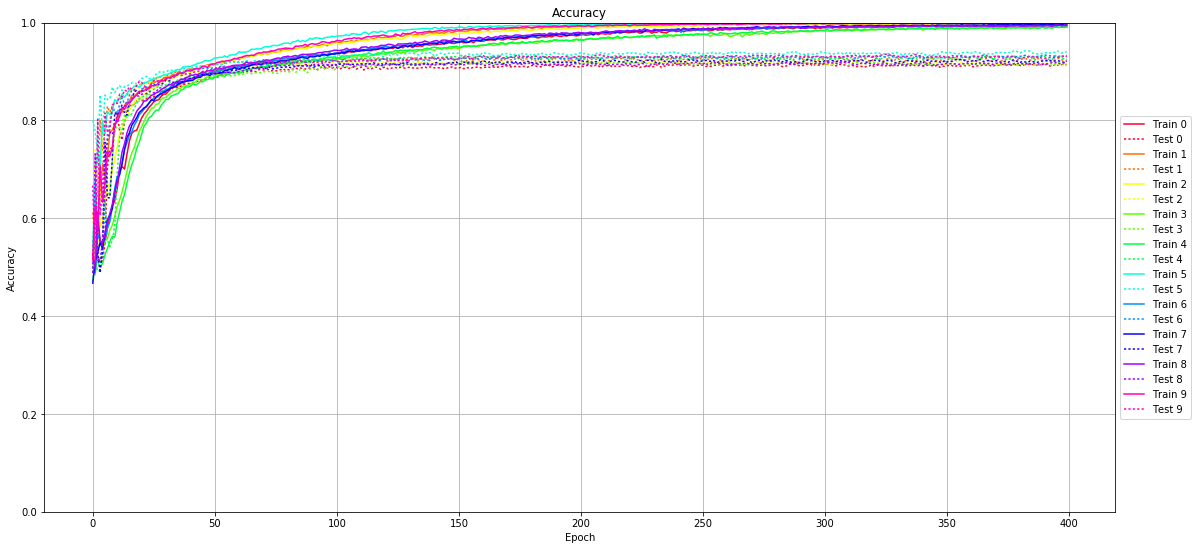

In [14]:
plot_acc(history)

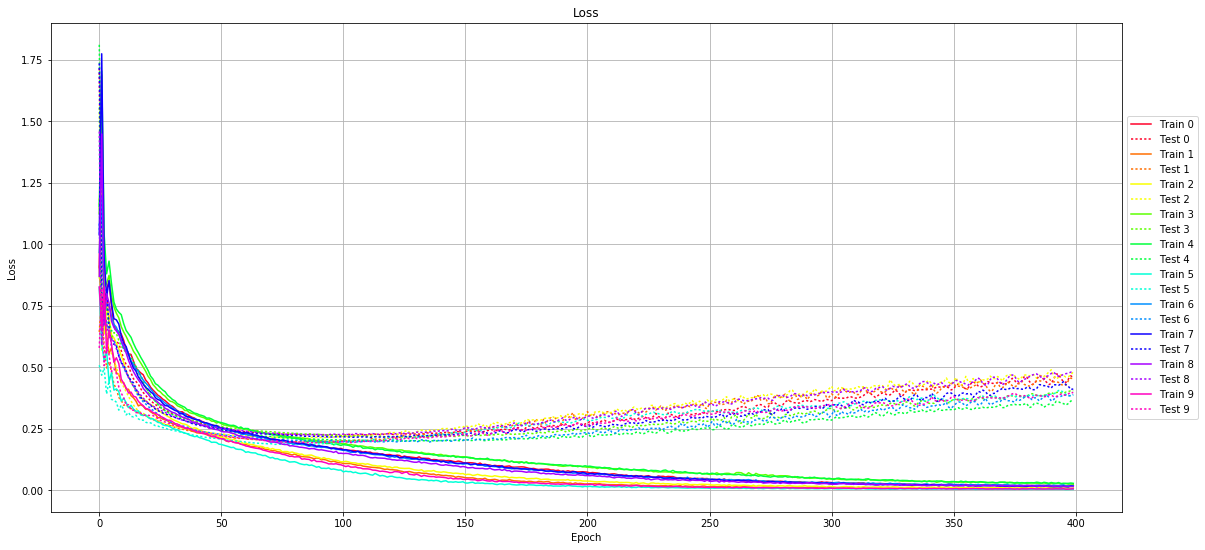

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


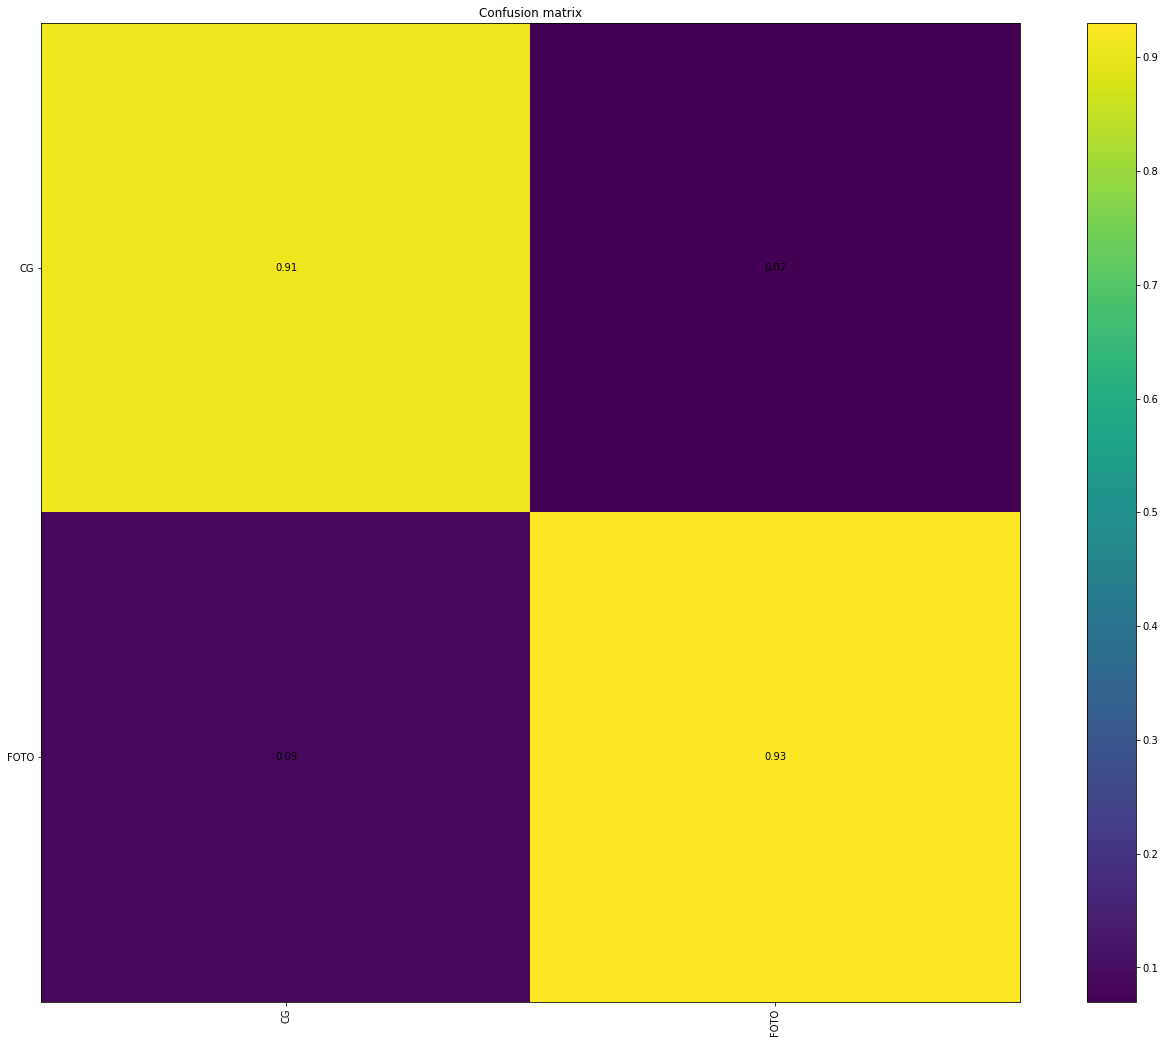

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()